

This notebook contains an example for teaching.


# Penalized Linear Regressions: A Simulation Experiment

## Data Generating Process: Approximately Sparse

[1] "theoretical R2:"   "0.826881788964026"


0.8268818


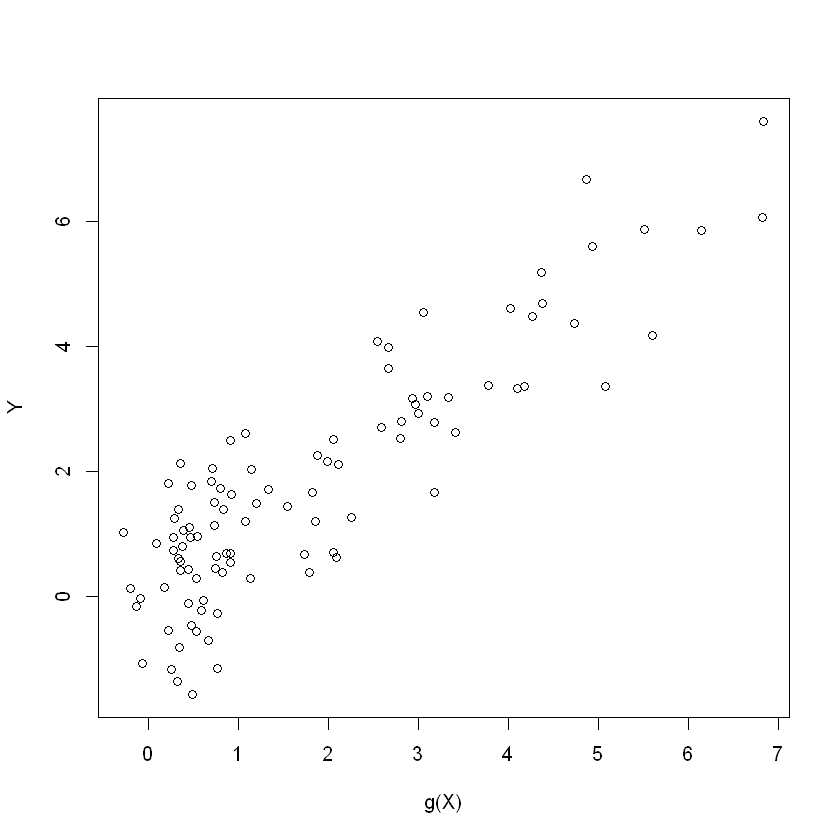

In [7]:
set.seed(1)

n = 100;
p = 400;

Z= runif(n)-1/2;
W = matrix(runif(n*p)-1/2, n, p);



beta = 1/seq(1:p)^2;   # approximately sparse beta
#beta = rnorm(p)*.2    # dense beta
gX = exp(4*Z)+ W%*%beta;  # leading term nonlinear
X = cbind(Z, Z^2, Z^3, W );  # polynomials in Zs will be approximating exp(4*Z)


Y = gX + rnorm(n);    #generate Y


plot(gX,Y, xlab="g(X)", ylab="Y")    #plot V vs g(X)

print( c("theoretical R2:", var(gX)/var(Y)))

var(gX)/var(Y); #theoretical R-square in the simulation example





In [8]:
dim(X)

[1] 100 403

We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net

In [18]:


library(glmnet)
fit.lasso.cv   <- cv.glmnet(X, Y, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge   <- cv.glmnet(X, Y, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet   <- cv.glmnet(X, Y, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = X)            # predictions
yhat.ridge   <- predict(fit.ridge, newx = X)
yhat.elnet   <- predict(fit.elnet, newx = X)

MSE.lasso.cv <- summary(lm((gX-yhat.lasso.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge <- summary(lm((gX-yhat.ridge)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet <- summary(lm((gX-yhat.elnet)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
b

ERROR: Error in eval(expr, envir, enclos): object 'b' not found


Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

In [3]:
library(hdm) 
fit.rlasso  <- rlasso(Y~X,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post <- rlasso(Y~X,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso   <- predict(fit.rlasso)            #predict g(X) for values of X
yhat.rlasso.post   <- predict(fit.rlasso.post)  #predict g(X) for values of X

MSE.lasso <- summary(lm((gX-yhat.rlasso)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post <- summary(lm((gX-yhat.rlasso.post)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)



Next we code up lava, which alternates the fitting of lasso and ridge

In [4]:
library(glmnet)

lava.predict<- function(X,Y, iter=5){
    
g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    
i=1
while(i<= iter) {
g1 = predict(rlasso(X, Y, post=F))   #lasso step fits "sparse part"
m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
i = i+1 }

return(g1+m1);
    }


yhat.lava = lava.predict(X,Y)
MSE.lava <- summary(lm((gX-yhat.lava)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

    
MSE.lava

[1] 0.16013551 0.02531404

In [5]:
library(xtable)
table<- matrix(0, 6, 2)
table[1,1:2]   <- MSE.lasso.cv
table[2,1:2]   <- MSE.ridge
table[3,1:2]   <- MSE.elnet
table[4,1:2]   <- MSE.lasso
table[5,1:2]   <- MSE.lasso.post
table[6,1:2]   <- MSE.lava

colnames(table)<- c("MSA", "S.E. for MSA")
rownames(table)<- c("Cross-Validated Lasso", "Cross-Validated ridge","Cross-Validated elnet",
                    "Lasso","Post-Lasso","Lava")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab



% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Mon Feb 15 11:02:51 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & MSA & S.E. for MSA \\ 
  \hline
Cross-Validated Lasso & 0.367 & 0.061 \\ 
  Cross-Validated ridge & 2.384 & 0.370 \\ 
  Cross-Validated elnet & 0.399 & 0.064 \\ 
  Lasso & 0.148 & 0.027 \\ 
  Post-Lasso & 0.085 & 0.009 \\ 
  Lava & 0.160 & 0.025 \\ 
   \hline
\end{tabular}
\end{table}


,MSA,S.E. for MSA
,<dbl>,<dbl>
Cross-Validated Lasso,0.3666009,0.061279916
Cross-Validated ridge,2.3842559,0.369909988
Cross-Validated elnet,0.3988608,0.063757963
Lasso,0.1482190,0.026705771
Post-Lasso,0.0845236,0.009469643
Lava,0.1601355,0.025314036


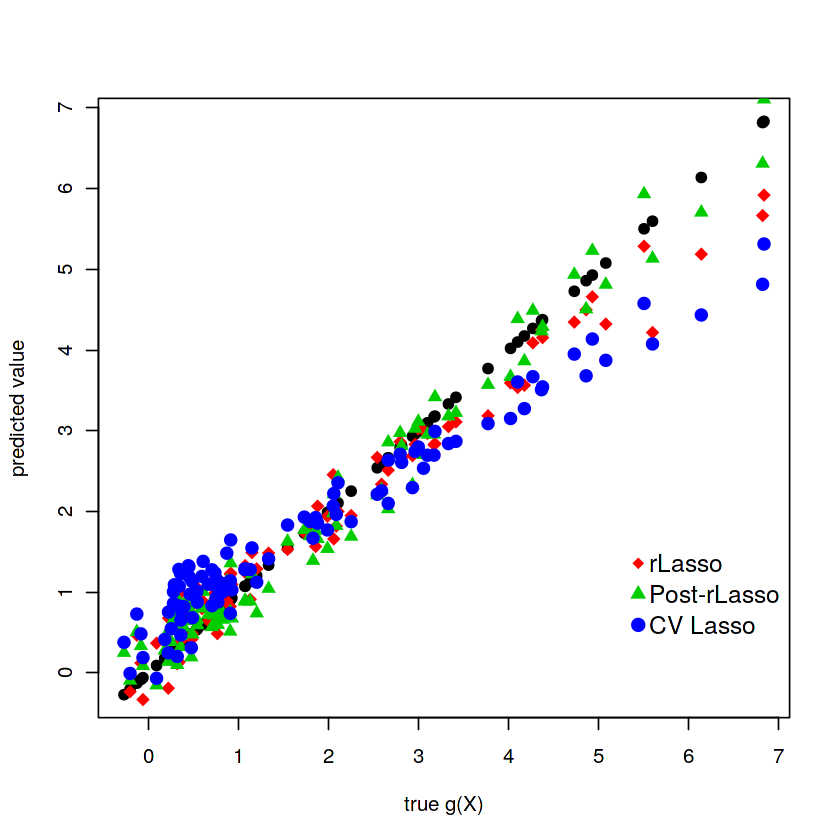

In [6]:

plot(gX, gX, pch=19, cex=1, ylab="predicted value", xlab="true g(X)")

points(gX, yhat.rlasso, col=2, pch=18, cex = 1.5 )
points(gX,  yhat.rlasso.post, col=3, pch=17,  cex = 1.2  )
points( gX, yhat.lasso.cv,col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("rLasso", "Post-rLasso", "CV Lasso"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))



## Data Generating Process: Approximately Sparse + Small Dense Part

[1] "theoretical R2:"   "0.696687990094227"


0.696688


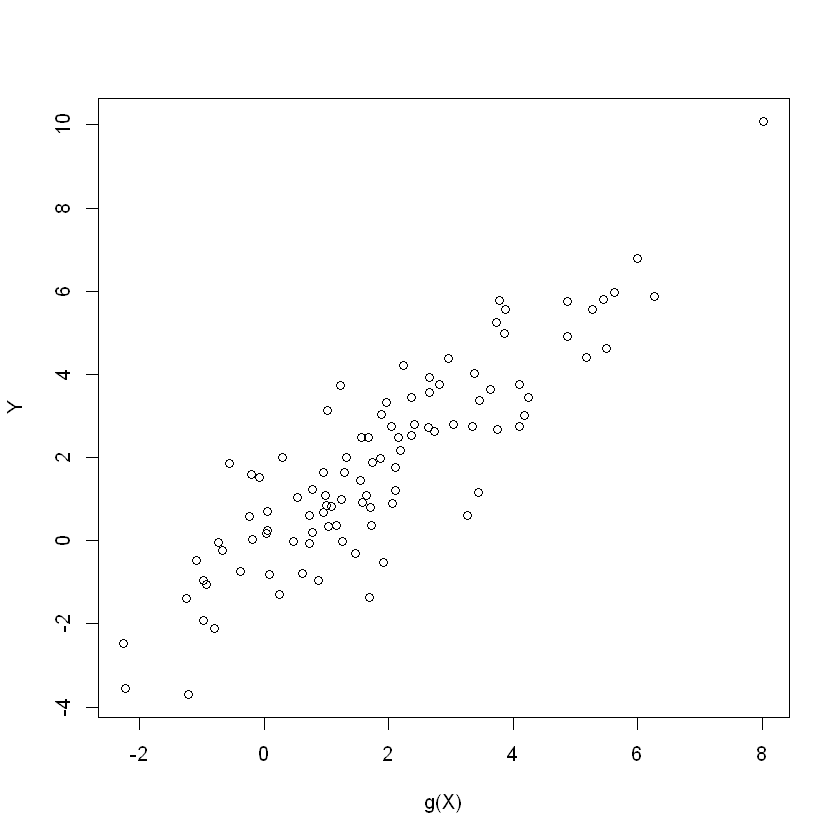

In [1]:
set.seed(1)

n = 100;
p = 400;

Z= runif(n)-1/2;
W = matrix(runif(n*p)-1/2, n, p);


beta = rnorm(p)*.2    # dense beta
gX = exp(4*Z)+ W%*%beta;  # leading term nonlinear
X = cbind(Z, Z^2, Z^3, W );  # polynomials in Zs will be approximating exp(4*Z)


Y = gX + rnorm(n);    #generate Y


plot(gX,Y, xlab="g(X)", ylab="Y")    #plot V vs g(X)

print( c("theoretical R2:", var(gX)/var(Y)))

var(gX)/var(Y); #theoretical R-square in the simulation example

In [7]:
rnorm(p)

[1]  0.489994246 -0.068888847 -1.782517190  0.424421055  1.711308452
  [6]  0.494244907 -0.578872467  1.839689644 -1.621155322  0.545284097
 [11] -0.213036534  0.271903620  0.543632663  0.424208042  0.959583347
 [16] -0.442402221 -1.680465979  0.162041127  2.716844083  0.129141443
 [21]  1.089741674  1.235244841  0.239096457  0.512635655 -0.284461400
 [26]  3.147502088  1.469683175  1.309090640  0.748065310 -1.919657507
 [31] -1.458923044 -0.837179966 -0.673807527  1.068304856 -0.318388821
 [36]  0.334272031 -1.231309852  1.080639261  0.487631283  0.506837250
 [41]  0.458031822  0.234707386 -0.521772464 -1.088003390  1.204463812
 [46]  0.862578402  0.080975530  1.042465979 -1.420667876 -0.682267401
 [51] -1.776266815 -2.010599411 -1.272666980 -0.704897001  1.037769856
 [56] -0.237575452  0.905238904 -0.155904614 -0.502205898  2.606409671
 [61] -1.077342907  0.017045153  0.095334474  1.050253504 -0.362110355
 [66]  0.466644845  0.593588867 -2.280492558 -0.346268369 -0.150877581
 [71]  0.346941082  0.582181920 -0.309600869 -0.178702598  0.843100653
 [76] -0.450477715 -0.975766829 -1.530512052  0.417837394  1.278333341
 [81]  0.873900421 -0.696347945 -2.748350744  0.306740318 -0.233118982
 [86]  0.911667933 -1.992414232  1.708157133  1.142085585  0.887983635
 [91] -0.041186091  1.341948683 -0.577611750  0.352509013 -0.074265968
 [96] -0.331490562 -0.234603004 -1.068892040  0.425833404  0.692986563
[101]  1.551575277 -0.629810015 -1.845636440 -0.322683692  0.557338216
[106]  0.508981195  1.719634173  0.241335906  0.920405466 -0.383980038
[111]  1.089631781 -0.386653466 -1.255528569  0.436820418 -0.304604126
[116]  0.567154457 -0.079614028 -1.608027238  0.053968385 -0.071699162
[121] -0.221459689 -0.880219950 -1.081456721 -1.101571039 -1.243499933
[126] -1.220181696 -0.317130038  0.491485119  0.849354939  0.560688817
[131]  0.085757472 -0.586660273  1.302445484 -2.427462758 -0.691774326
[136]  0.339305732  0.197239341 -0.005361051  0.780392399  0.693197496
[141] -0.628422927  0.254706986  1.410714990  1.110920601 -0.601774634
[146] -0.664947954 -0.378221241 -0.339591191  0.021605766  0.634463862
[151]  0.814105285 -1.668041694 -0.077100507  1.023242175 -0.613683364
[156]  0.033184937  0.291507312 -0.870023073  1.286854106 -0.097578468
[161] -0.369385131  0.932501392  0.015382344  1.289582343  1.593941972
[166]  0.521131618  0.484630785  1.830374896  0.570806817  1.032027770
[171] -0.234818320 -0.420685640 -1.226080921 -0.459464076  0.527088735
[176]  0.597897711 -0.488016917 -0.357791737 -0.451391332  1.029995684
[181] -0.893396070 -1.883227075 -0.199193925 -1.762344803  0.193954873
[186] -0.469739938 -0.632557130 -1.725885509 -2.046737476  0.664635147
[191] -1.466876660 -0.396933970 -0.792452134 -0.097685615  1.882920142
[196]  0.861071362 -0.424941917 -0.412130400  0.603479659  0.969537832
[201]  1.263194400  0.093380761 -0.328338911  0.640087568 -1.567638905
[206] -0.733373877  0.464676505 -0.524174310  0.543323390 -0.665844983
[211] -0.819215194  1.039665720 -1.276651027 -1.120150244  0.152438737
[216]  1.464603273 -2.148943547 -1.220400624 -1.265022635 -0.293232271
[221] -0.448079557  1.789725211 -0.827985907  2.439315076  0.521337237
[226] -1.081263075 -0.694468534 -0.143766970 -0.323208454  0.890053091
[231]  0.965310588 -0.579230396 -1.307810892  0.728696301  0.888421890
[236] -0.087450628 -1.836791736  0.781318046 -0.007240176  0.624355452
[241]  0.005375939 -0.877772252 -1.021998444  0.420961933 -0.416487976
[246]  1.187796080  0.738902835 -1.346851945 -1.815156957 -1.080283123
[251] -1.509375569  0.583236657  0.234483672 -0.624421849  1.171938471
[256] -1.349689163  0.155775984  1.209294674 -1.708994381  1.124562781
[261]  0.660256874 -0.739237352 -1.258471453 -0.807217129  1.465645518
[266] -1.084802391 -0.121942760 -0.801442274  0.073048850 -0.738157347
[271]  0.106413455 -1.023239675 -0.171290174 -0.709325234  1.126886264
[276]  0.011147262  0.840580259 -0.567686389  1.851589351 -0.500991423
[281]  1.385974470  1.3775

In [8]:

library(glmnet)
fit.lasso.cv   <- cv.glmnet(X, Y, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge   <- cv.glmnet(X, Y, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet   <- cv.glmnet(X, Y, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = X)            # predictions
yhat.ridge   <- predict(fit.ridge, newx = X)
yhat.elnet   <- predict(fit.elnet, newx = X)

MSE.lasso.cv <- summary(lm((gX-yhat.lasso.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge <- summary(lm((gX-yhat.ridge)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet <- summary(lm((gX-yhat.elnet)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)


In [9]:
library(hdm) 
fit.rlasso  <- rlasso(Y~X,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post <- rlasso(Y~X,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso   <- predict(fit.rlasso)            #predict g(X) for values of X
yhat.rlasso.post   <- predict(fit.rlasso.post)  #predict g(X) for values of X

MSE.lasso <- summary(lm((gX-yhat.rlasso)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post <- summary(lm((gX-yhat.rlasso.post)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)



In [10]:
library(glmnet)

lava.predict<- function(X,Y, iter=5){
    
g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    
i=1
while(i<= iter) {
g1 = predict(rlasso(X, Y, post=F))   #lasso step fits "sparse part"
m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
i = i+1 }

return(g1+m1);
    }


yhat.lava = lava.predict(X,Y)
MSE.lava <- summary(lm((gX-yhat.lava)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

    
MSE.lava

[1] 0.6614552 0.0724484

In [11]:
library(xtable)
table<- matrix(0, 6, 2)
table[1,1:2]   <- MSE.lasso.cv
table[2,1:2]   <- MSE.ridge
table[3,1:2]   <- MSE.elnet
table[4,1:2]   <- MSE.lasso
table[5,1:2]   <- MSE.lasso.post
table[6,1:2]   <- MSE.lava

colnames(table)<- c("MSA", "S.E. for MSA")
rownames(table)<- c("Cross-Validated Lasso", "Cross-Validated ridge","Cross-Validated elnet",
                    "Lasso","Post-Lasso","Lava")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab


% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Mon Feb 15 11:04:15 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & MSA & S.E. for MSA \\ 
  \hline
Cross-Validated Lasso & 1.932 & 0.291 \\ 
  Cross-Validated ridge & 3.411 & 0.494 \\ 
  Cross-Validated elnet & 1.825 & 0.252 \\ 
  Lasso & 0.964 & 0.120 \\ 
  Post-Lasso & 1.597 & 0.207 \\ 
  Lava & 0.661 & 0.072 \\ 
   \hline
\end{tabular}
\end{table}


,MSA,S.E. for MSA
,<dbl>,<dbl>
Cross-Validated Lasso,1.9318225,0.2913049
Cross-Validated ridge,3.4106685,0.4942650
Cross-Validated elnet,1.8251591,0.2518995
Lasso,0.9641151,0.1197804
Post-Lasso,1.5966018,0.2070796
Lava,0.6614552,0.0724484


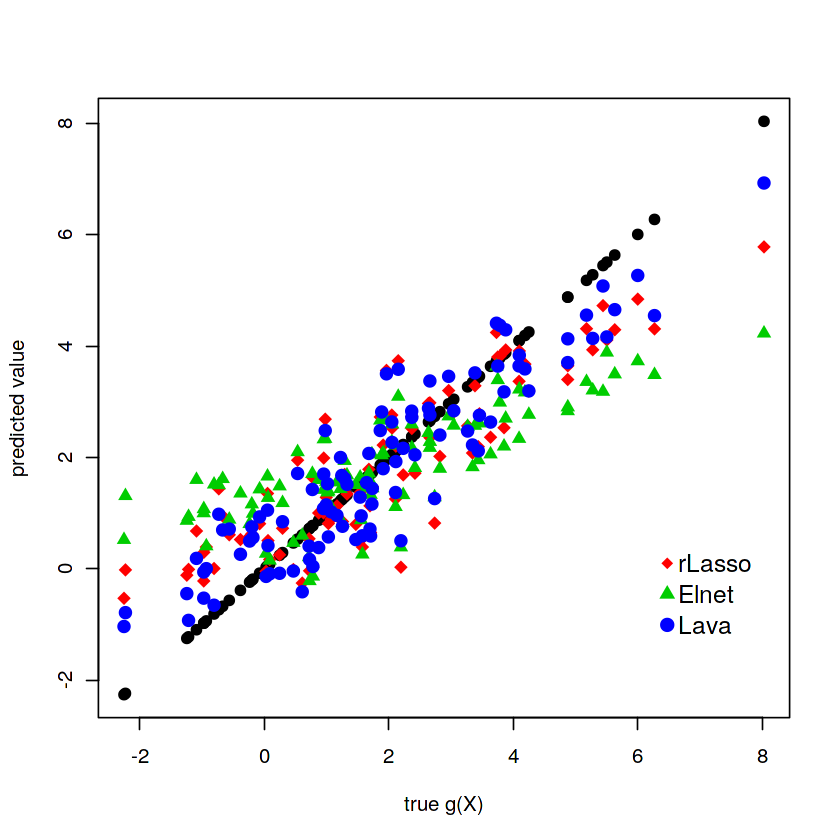

In [12]:

plot(gX, gX, pch=19, cex=1, ylab="predicted value", xlab="true g(X)")

points(gX, yhat.rlasso,   col=2, pch=18, cex = 1.5 )
points(gX, yhat.elnet,  col=3, pch=17,  cex = 1.2  )
points(gX, yhat.lava,  col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("rLasso", "Elnet", "Lava"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))
